In [2]:
pip install torch torchvision matplotlib

In [3]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 17.5 MB/s eta 0:00:00


In [4]:
import os
import time
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
#Establishing images paths for the models
image_paths = [
    "/content/3f71fb47-ab4a-4a0d-8b39-96372f541868.jpg",
    "/content/IMG_1113.jpeg",
    "/content/IMG_1352.jpeg",
    "/content/IMG_4897.jpeg",
    "/content/IMG_7973.jpeg",
]

output_dir = '/content/output_images/'
os.makedirs(output_dir, exist_ok=True)

In [6]:
#This are the two models that i'm going to use for this assigment:
faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True).eval() #Faster R-CNN

yolo_model = YOLO('yolov8n.pt')  # YOLOv8 nano model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 69.8MB/s]


100%|██████████| 6.25M/6.25M [00:00<00:00, 92.5MB/s]


In [7]:
# First Model:  Faster R-CNN

#adding coco labels to train model
COCO_LABELS = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane", 6: "bus", 7: "train", 8: "truck",
    9: "boat", 10: "traffic light", 11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep", 21: "cow", 22: "elephant", 23: "bear",
    24: "zebra", 25: "giraffe", 27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite", 39: "baseball bat",
    40: "baseball glove", 41: "skateboard", 42: "surfboard", 43: "tennis racket", 44: "bottle",
    46: "wine glass", 47: "cup", 48: "fork", 49: "knife", 50: "spoon", 51: "bowl", 52: "banana",
    53: "apple", 54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch", 64: "potted plant", 65: "bed",
    67: "dining table", 70: "toilet", 72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink", 82: "refrigerator",
    84: "book", 85: "clock", 86: "vase", 87: "scissors", 88: "teddy bear", 89: "hair drier",
    90: "toothbrush"
}

#Defining Faster R-CNN function
def run_faster_rcnn(image, img_tensor, file_name):
    start_time = time.time()
    with torch.no_grad():
        predictions = faster_rcnn_model(img_tensor)[0]
    detection_time = time.time() - start_time

    # Count objects and calculate average confidence
    num_objects = sum(score > 0.5 for score in predictions['scores'])
    avg_confidence = torch.mean(predictions['scores']).item() if predictions['scores'].size(0) > 0 else 0

    # Visualize results
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()
    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Display the label and confidence score
            label_name = COCO_LABELS.get(label.item(), "Unknown")
            text = f"{label_name}: {score:.2f}"
            ax.text(
                x1,
                y1 - 10,
                text,
                color="yellow",
                fontsize=10,
                backgroundcolor="blue",
            )
    plt.axis('off')
    plt.title(f"Faster R-CNN Predictions: {file_name}")
    plt.show()

    return detection_time, num_objects, avg_confidence

In [8]:
# Second Model: Yolov8

#Defining YOLOv8 function
def run_yolov8(image_path, file_name):
    start_time = time.time()
    results = yolo_model(image_path)
    detection_time = time.time() - start_time

    # Count objects and calculate average confidence
    num_objects = len(results[0].boxes.xyxy)
    avg_confidence = results[0].boxes.conf.mean().item() if len(results[0].boxes.xyxy) > 0 else 0

    # Visualize results
    annotated_image = results[0].plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.title(f"YOLOv8 Predictions: {file_name}")
    plt.show()

    return detection_time, num_objects, avg_confidence

Processing Faster R-CNN for: 3f71fb47-ab4a-4a0d-8b39-96372f541868.jpg


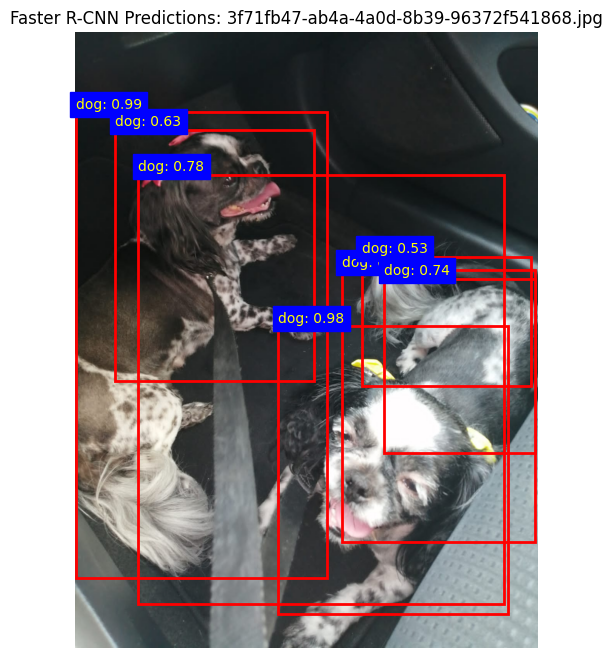

Processing YOLOv8 for: 3f71fb47-ab4a-4a0d-8b39-96372f541868.jpg

image 1/1 /content/3f71fb47-ab4a-4a0d-8b39-96372f541868.jpg: 640x480 1 person, 3 dogs, 191.4ms
Speed: 16.6ms preprocess, 191.4ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 480)


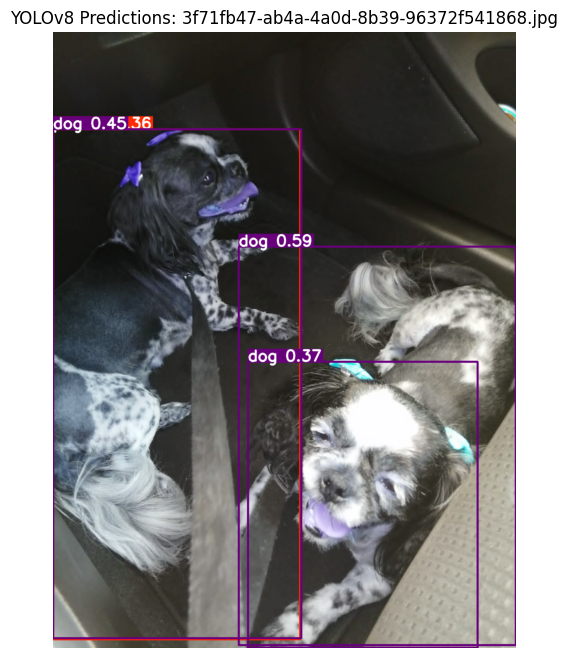


Results for 3f71fb47-ab4a-4a0d-8b39-96372f541868.jpg:

Faster R-CNN - Detection Time: 13.90s, Objects Detected: 7, Avg Confidence: 0.29
YOLOv8      - Detection Time: 1.69s, Objects Detected: 4, Avg Confidence: 0.44

--------------------------------------------------

Processing Faster R-CNN for: IMG_1113.jpeg


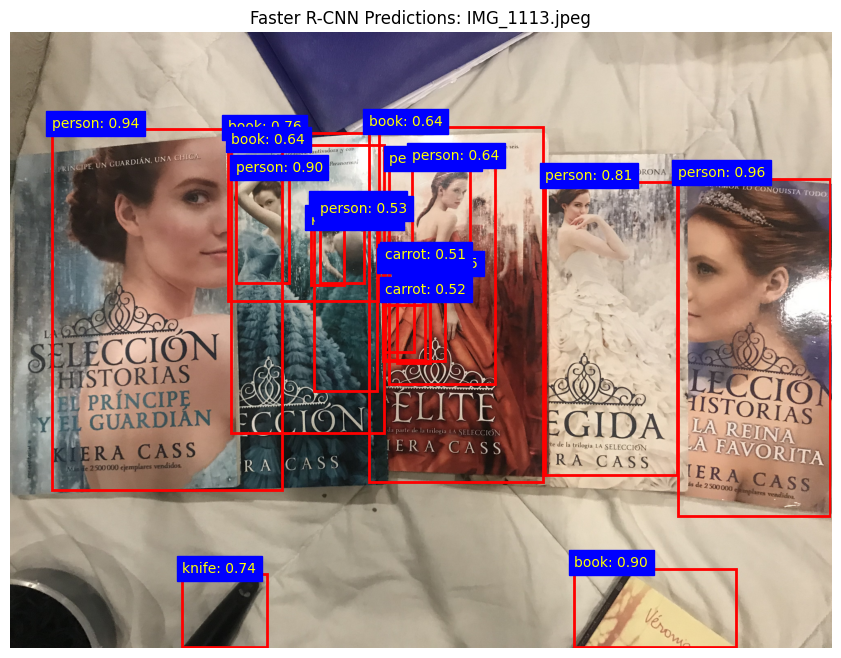

Processing YOLOv8 for: IMG_1113.jpeg

image 1/1 /content/IMG_1113.jpeg: 640x480 1 bed, 1 book, 225.8ms
Speed: 5.5ms preprocess, 225.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


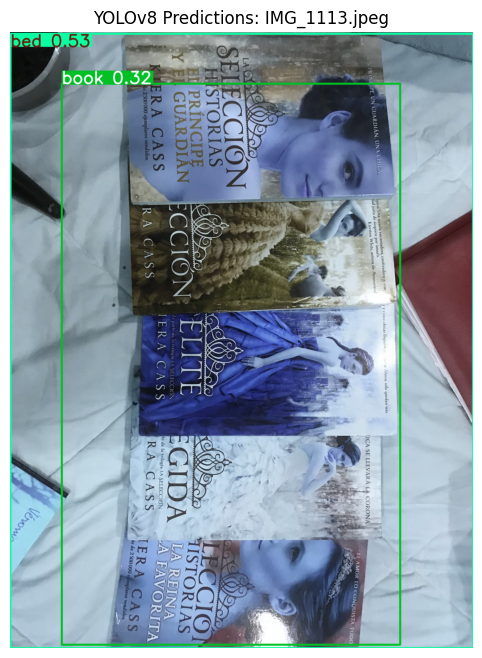


Results for IMG_1113.jpeg:

Faster R-CNN - Detection Time: 8.34s, Objects Detected: 19, Avg Confidence: 0.33
YOLOv8      - Detection Time: 0.44s, Objects Detected: 2, Avg Confidence: 0.43

--------------------------------------------------

Processing Faster R-CNN for: IMG_1352.jpeg


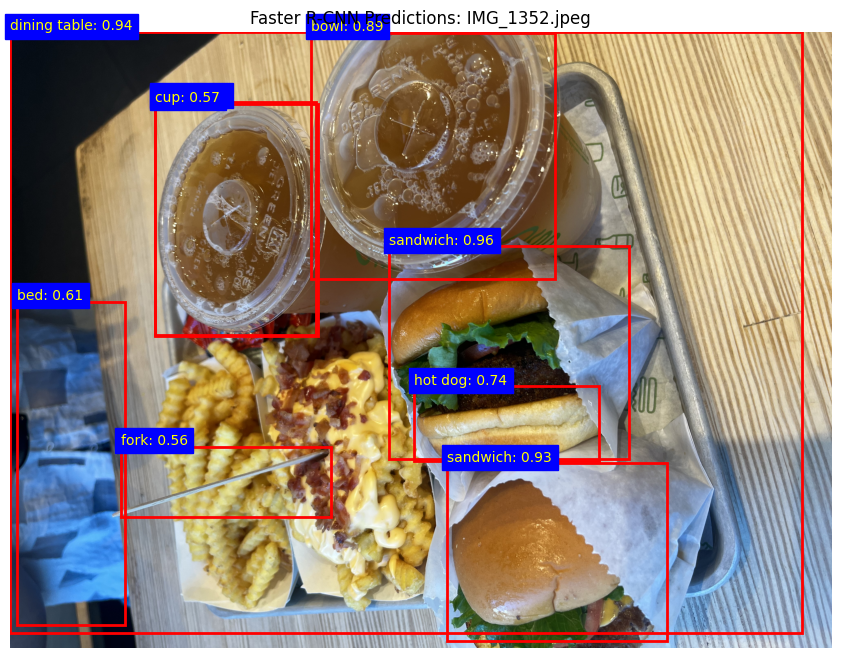

Processing YOLOv8 for: IMG_1352.jpeg

image 1/1 /content/IMG_1352.jpeg: 640x480 2 persons, 1 cup, 2 bowls, 3 sandwichs, 2 dining tables, 245.1ms
Speed: 6.0ms preprocess, 245.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


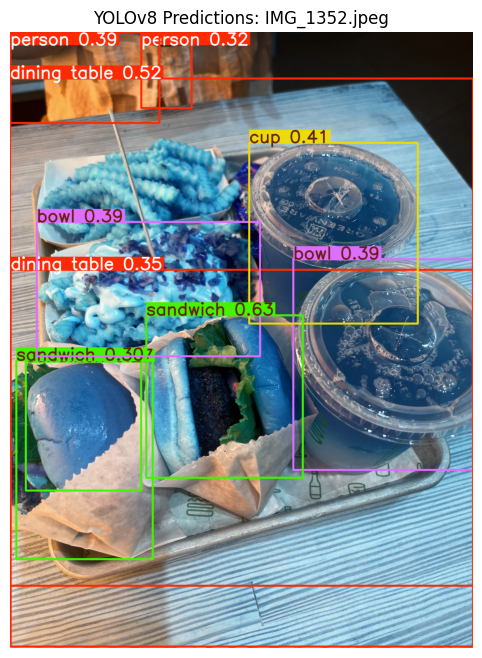


Results for IMG_1352.jpeg:

Faster R-CNN - Detection Time: 8.29s, Objects Detected: 9, Avg Confidence: 0.28
YOLOv8      - Detection Time: 0.46s, Objects Detected: 10, Avg Confidence: 0.40

--------------------------------------------------

Processing Faster R-CNN for: IMG_4897.jpeg


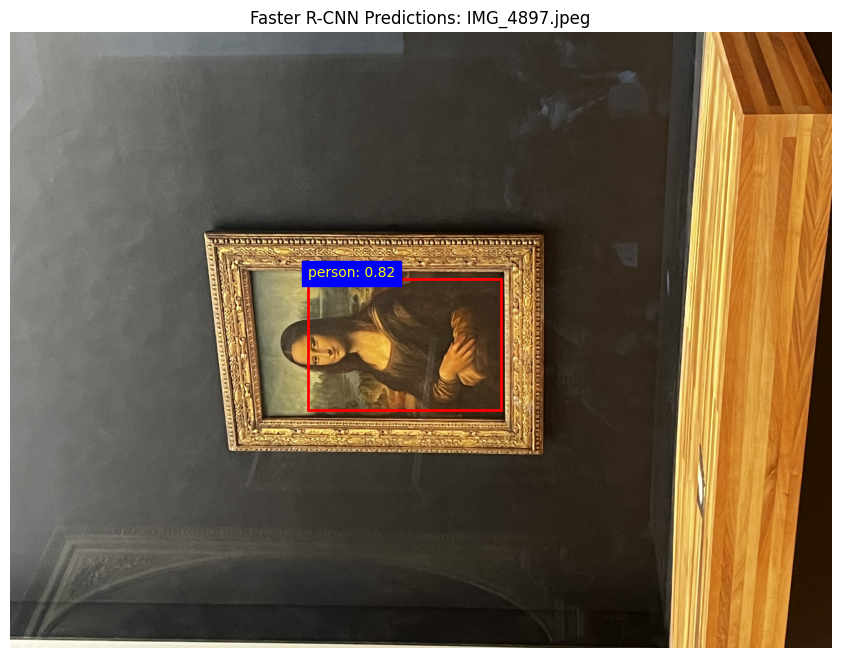

Processing YOLOv8 for: IMG_4897.jpeg

image 1/1 /content/IMG_4897.jpeg: 640x480 1 person, 234.4ms
Speed: 8.9ms preprocess, 234.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


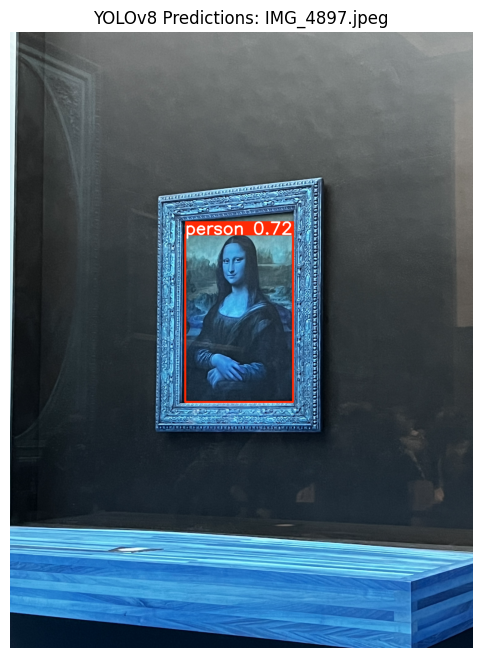


Results for IMG_4897.jpeg:

Faster R-CNN - Detection Time: 7.96s, Objects Detected: 1, Avg Confidence: 0.23
YOLOv8      - Detection Time: 0.46s, Objects Detected: 1, Avg Confidence: 0.72

--------------------------------------------------

Processing Faster R-CNN for: IMG_7973.jpeg


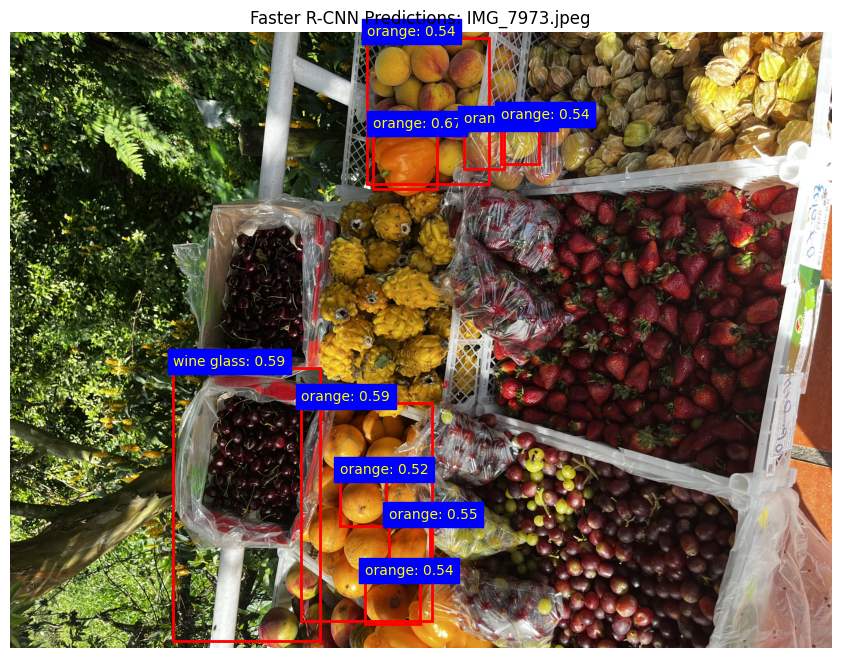

Processing YOLOv8 for: IMG_7973.jpeg

image 1/1 /content/IMG_7973.jpeg: 640x480 4 oranges, 254.7ms
Speed: 5.6ms preprocess, 254.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


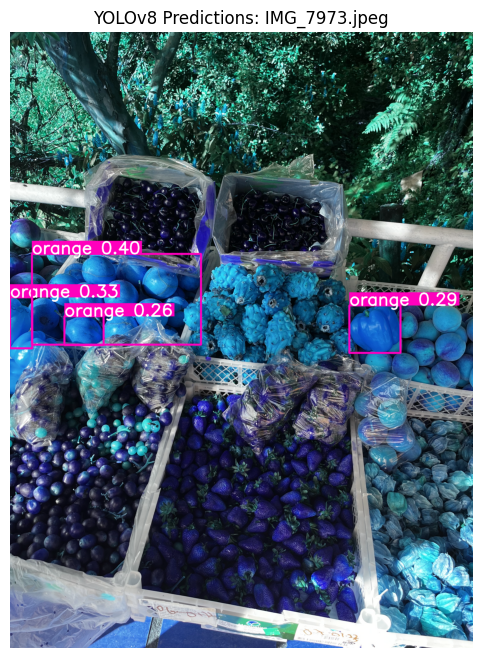


Results for IMG_7973.jpeg:

Faster R-CNN - Detection Time: 8.22s, Objects Detected: 9, Avg Confidence: 0.20
YOLOv8      - Detection Time: 0.44s, Objects Detected: 4, Avg Confidence: 0.32

--------------------------------------------------



In [9]:
#Printing images and object detected with each model
comparison_data = []

# Process each image
for img_path in image_paths:
    if os.path.exists(img_path):

        image = Image.open(img_path).convert("RGB")
        img_tensor = F.to_tensor(image).unsqueeze(0)

        file_name = os.path.basename(img_path)

        # Faster R-CNN
        print(f"Processing Faster R-CNN for: {file_name}")
        rc_time, rc_objects, rc_avg_conf = run_faster_rcnn(image, img_tensor, file_name)
        comparison_data.append({
            "Image": file_name,
            "Model": "Faster R-CNN",
            "Detection Time (s)": rc_time,
            "Number of Objects Detected": rc_objects,
            "Average Confidence": rc_avg_conf,
        })

        # YOLOv8
        print(f"Processing YOLOv8 for: {file_name}")
        yolo_time, yolo_objects, yolo_avg_conf = run_yolov8(img_path, file_name)
        comparison_data.append({
            "Image": file_name,
            "Model": "YOLOv8",
            "Detection Time (s)": yolo_time,
            "Number of Objects Detected": yolo_objects,
            "Average Confidence": yolo_avg_conf,
        })

        # Printin Faster R-CNN and YOLOv8 comparison
        print(f"\nResults for {file_name}:\n")
        print(f"Faster R-CNN - Detection Time: {rc_time:.2f}s, Objects Detected: {rc_objects}, Avg Confidence: {rc_avg_conf:.2f}")
        print(f"YOLOv8      - Detection Time: {yolo_time:.2f}s, Objects Detected: {yolo_objects}, Avg Confidence: {yolo_avg_conf:.2f}")
        print("\n" + "-" * 50 + "\n")
    else:
        print(f"Image not found: {img_path}")


PART II


In [10]:
from sklearn.cluster import KMeans
import numpy as np

#For Part II: we are going to extract dominant colors to further analyze the pictures
def extract_dominant_colors(image, num_colors=5):
    img_resized = image.resize((100, 100))
    img_array = np.array(img_resized).reshape(-1, 3)

    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(img_array)

    colors = kmeans.cluster_centers_.astype(int)
    return colors

for img_path in image_paths:
    if os.path.exists(img_path):
        print(f"Processing: {img_path}")

        # Open the image
        image = Image.open(img_path)

        # Extract dominant colors
        dominant_colors = extract_dominant_colors(image)
        print(f"Dominant Colors for {img_path}: {dominant_colors}")

Processing: /content/3f71fb47-ab4a-4a0d-8b39-96372f541868.jpg
Dominant Colors for /content/3f71fb47-ab4a-4a0d-8b39-96372f541868.jpg: [[164 169 168]
 [ 64  65  65]
 [ 29  33  33]
 [121 119 117]
 [226 223 218]]
Processing: /content/IMG_1113.jpeg
Dominant Colors for /content/IMG_1113.jpeg: [[180 163 144]
 [ 92  77  79]
 [146 120 106]
 [217 203 182]
 [ 50  42  40]]
Processing: /content/IMG_1352.jpeg
Dominant Colors for /content/IMG_1352.jpeg: [[140 163 191]
 [ 27  29  29]
 [103  81  56]
 [150 132 103]
 [207 189 144]]
Processing: /content/IMG_4897.jpeg
Dominant Colors for /content/IMG_4897.jpeg: [[ 90  83  72]
 [218 179 100]
 [ 49  42  33]
 [190 127  55]
 [126 125 118]]
Processing: /content/IMG_7973.jpeg
Dominant Colors for /content/IMG_7973.jpeg: [[ 89  70  44]
 [176 158 115]
 [ 39  30  18]
 [144 114  61]
 [216 214 203]]
